In [24]:
import argparse
import h5py
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import cv2

from dataset import EmbeddingDataset
from transformer import Transformer

In [25]:
OPENSLIDE_PATH = r'C:\Users\heeryung\anaconda3\envs\jiwon2\Lib\site-packages\openslide-bin-4.0.0.3-windows-x64\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [52]:
feature_path = 'D:/TCGA_STAD/CTransPath_feat_test/7c6180f0-e8ac-49f8-b1a4-a3e175d6e2e7.h5'
slide_path = 'D:/TCGA_STAD/TCGA_STAD/7c6180f0-e8ac-49f8-b1a4-a3e175d6e2e7/TCGA-BR-6563-01Z-00-DX1.2398c0e0-47a6-4557-8e2d-3b890756900a.svs'

h5_file = h5py.File(feature_path)
features = torch.Tensor(np.array(h5_file['features'])).unsqueeze(0)
name = np.array(h5_file['filenames'])

coords = []
for item in name:
    x, y, *_ = item.decode().split('_')
    coords.append((int(x), int(y)))
coords = torch.Tensor(coords)
coords = [(coords[i, 0].int().item(), coords[i, 1].int().item()) for i in range(coords.shape[0])]

slide = openslide.open_slide(slide_path)
level = len(slide.level_downsamples) - 1
d = slide.level_downsamples[level]
image = slide.read_region((0, 0), level, slide.level_dimensions[level])
image = np.array(image.convert("RGB"))

In [45]:
model = Transformer(input_dim=768, num_classes=2)
model.load_state_dict(torch.load('D:/TCGA_STAD/transformer_ckpt/trial3/ckpt_200.pth'))
model.eval()

Transformer(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
  )
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=2, bias=True)
  )
  (transformer): TransformerBlocks(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): GELU(approximate='none')
              

### Load plotting utils 

In [47]:
# function that plots scores nicely. scores should have the same length as the number of tiles.
def NormalizeData(data):
    return (data - data.min()) / (data.max() - data.min())

def plot_scores(coords, scores, image, overlay=True, clamp=0.05, norm=True, colormap='RdBu', crop=False, indices=[]):
    if clamp:
        q05, q95 = torch.quantile(scores, clamp), torch.quantile(scores, 1-clamp)
        scores.clamp_(q05,q95)
    
    if norm:
        scores = NormalizeData(scores)
        
    if crop:
        coords_min, coords_max = np.array(coords).min(axis=0), np.array(coords).max(axis=0)
        y_min, y_max, x_min, x_max = round(coords_min[1]/d), round(coords_max[1]/d), round(coords_min[0]/d), round(coords_max[0]/d)
        # if slide_path.stem == '439042':
        #     x_max = round((69 * 1013)/d)
        # print(y_min, y_max, x_min, x_max)
    else:
        y_min, y_max, x_min, x_max = 0, image.shape[0], 0, image.shape[1]
        
        
    attention_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
    tissue_map = -np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    
    offset = 2100
    for (x,y), s in zip(coords, scores):
        
        if colormap == 'RdBu': 
            attention_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = 1 - s.item()
        else: 
            attention_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = s.item()
        tissue_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = s.item()
       
    attention_map = np.array(attention_map * 255., dtype=np.uint8)
    tissue_map[tissue_map>=0] = 1
    tissue_map[tissue_map<0] = 0

    if len(indices) != 0:
        highlight_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)    
        for i in indices:
            x, y = coords[i]
            highlight_map[round(y/d):round((y+offset)/d), round(x/d):round((x+offset)/d)] = 1    
                 
#     plt.figure(figsize=(30, 30))
    a = 1.
    if overlay:
        plt.imshow(image[y_min:y_max, x_min:x_max])
        a = 0.5
    
    if crop:
        plt.imshow(attention_map[y_min:y_max, x_min:x_max], alpha=a*(tissue_map[y_min:y_max, x_min:x_max]), cmap=colormap, interpolation='nearest')
#         plt.imshow(attention_map[round(coords_min[1]/d):, round(coords_min[0]/d):], alpha=a*(tissue_map[round(coords_min[1]/d):, round(coords_min[0]/d):]), cmap=colormap, interpolation='nearest')
    else:
        plt.imshow(attention_map, alpha=a*(tissue_map), cmap=colormap, interpolation='nearest')
    
    if len(indices) != 0:
        plt.imshow(highlight_map[y_min:y_max, x_min:x_max], alpha=1.*(highlight_map), cmap='viridis', interpolation='nearest')
    
    plt.axis('off')

### Load attention utils

In [49]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

def generate_rollout(model, input, start_layer=0):
    model(input)
    blocks = model.transformer.layers
    all_layer_attentions = []
    for blk in blocks:
        attn_heads = blk[0].fn.get_attention_map()
        avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
        all_layer_attentions.append(avg_heads)
    rollout = compute_rollout_attention(all_layer_attentions, start_layer=start_layer)
    return rollout[:,0, 1:]

### 1) Compute attention scores

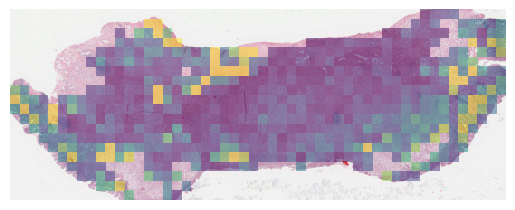

In [53]:
rollout = generate_rollout(model, features, start_layer=0).squeeze(0)

plot_scores(coords, rollout, image, overlay=True, colormap='viridis', crop=True)
plt.show()

### 2) Compute class score

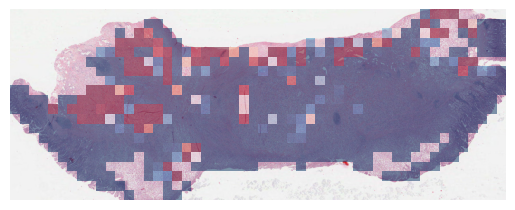

In [54]:
n = features.shape[1]
scores = np.zeros(n)

for i in range(n):
    out = model(features[:, i:i+1, :]).squeeze(0)
    probs = torch.softmax(out, dim=0)
    scores[i] = probs[1]
    # scores[i] = torch.sigmoid(out).item()  # Use the first element of out and convert to a Python scalar

plot_scores(coords, scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=False, crop=True)
plt.show()

### 3) Comput attention x class score

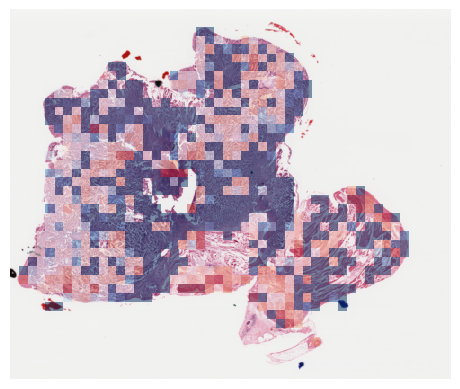

In [37]:
plot_scores(coords, rollout * scores, image, overlay=True, colormap='RdBu_r', clamp=False, norm=True)
plt.show()